In [37]:
# Python packages
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pickle
import signal
import argparse
import traceback
import json
import torch

In [3]:
# Project libraries
sys.path.insert(1, '../src/')

import embedding.factory as ebd
import classifier.factory as clf
import dataset.loader as loader
import train.factory as train_utils

I0323 11:48:47.632786 140472081618752 file_utils.py:39] PyTorch version 1.3.1 available.


In [128]:
cuda0 = torch.device('cuda:0')

## Arguments

In [51]:
# Build args
parser = argparse.ArgumentParser()
parser.add_argument("--data_path", type=str,
                        default="data/20news.json", # og: reuters
                        help="path to dataset")
parser.add_argument("--dataset", type=str, default="20newsgroup", # og: reuters
                    help="name of the dataset. "
                    "Options: [20newsgroup, amazon, huffpost, "
                    "reuters, rcv1, fewrel]")
parser.add_argument("--n_train_class", type=int, default=15,
                    help="number of meta-train classes")
parser.add_argument("--n_val_class", type=int, default=5,
                    help="number of meta-val classes")
parser.add_argument("--n_test_class", type=int, default=11,
                    help="number of meta-test classes")
parser.add_argument("--mode", type=str, default="test",
                    help=("Running mode."
                          "Options: [train, test, finetune]"
                          "[Default: test]"))
parser.add_argument("--wv_path", type=str,
                    default="./",
                    help="path to word vector cache")
parser.add_argument("--word_vector", type=str, default="wiki.en.vec",
                    help=("Name of pretrained word embeddings."))
parser.add_argument("--finetune_ebd", action="store_true", default=False,
                    help=("Finetune embedding during meta-training"))
parser.add_argument("--bert", default=False, action="store_true",
                    help=("set true if use bert embeddings "
                          "(only available for sent-level datasets: "
                          "huffpost, fewrel"))
parser.add_argument("--auxiliary", type=str, nargs="*", default=[],
                    help=("auxiliary embeddings (used for fewrel). "
                          "Options: [pos, ent]"))
parser.add_argument("--embedding", type=str, default="avg",
                    help=("document embedding method. Options: "
                          "[avg, tfidf, meta, oracle, cnn]"))
parser.add_argument("--meta_w_target", action="store_true", default=False,
                    help="use target importance score")
parser.add_argument("--cuda", type=int, default=-1,
                    help="cuda device, -1 for cpu")
parser.add_argument("--snapshot", type=str, default="",
                    help="path to the pretraiend weights")


# Populate parameters
args = parser.parse_args(["--data_path", "../data/20news.json",
                            "--dataset", "20newsgroup",
                            "--n_train_class", "8",
                            "--n_val_class", "5",
                            "--n_test_class", "7",
                            "--wv_path", "../",
                            "--cuda", "0",
                            "--finetune"
                            ])

print(vars(args))

{'data_path': '../data/20news.json', 'dataset': '20newsgroup', 'n_train_class': 8, 'n_val_class': 5, 'n_test_class': 7, 'mode': 'test', 'wv_path': '../', 'word_vector': 'wiki.en.vec', 'finetune_ebd': True, 'bert': False, 'auxiliary': [], 'embedding': 'avg', 'meta_w_target': False, 'cuda': 0, 'snapshot': ''}


## Load, Preprocess Data

In [97]:
train_data, _, test_data, vocab = loader.load_dataset(args)

20/03/23 13:37:47: Loading data from ../data/20news.json
20/03/23 13:37:48: Class balance:
{0: 940, 1: 987, 2: 972, 3: 775, 4: 973, 5: 991, 6: 980, 7: 985, 8: 910, 9: 628, 10: 990, 11: 990, 12: 961, 13: 981, 14: 999, 15: 799, 16: 994, 17: 982, 18: 994, 19: 997}
20/03/23 13:37:48: Avg len: 340.86015508816655
20/03/23 13:37:48: Loading word vectors


I0323 13:37:48.817018 140472081618752 vocab.py:431] Loading vectors from ../wiki.en.vec.pt


20/03/23 13:37:53: Total num. of words: 32137, word vector dimension: 300
20/03/23 13:37:53: Num. of out-of-vocabulary words(they are initialized to zeros): 9095
20/03/23 13:37:53: #train 7926, #val 4881, #test 6021


In [131]:
# Aggregate all training, val, test data
data = {}

for key in test_data:
    if key == 'vocab_size':
        data['vocab_size'] = test_data[key]
        continue
        
    ax = 0 if key == 'text' else None
    concat = np.concatenate(
            (test_data[key], train_data[key]), axis=ax
        )
    
    if key == 'text':
        data[key] = torch.tensor(concat, device=cuda0)
    else:
        data[key] = concat

assert len(data['text']) == len(test_data['text']) + len(train_data['text'])

print('Dataset has {} documents, {} different labels and {} size vocabulary.'.format(
    len(data['text']), max(data['label']), data['vocab_size'])
)

Dataset has 13947 documents, 19 different labels and 32137 size vocabulary.


In [132]:
model = {}
model["ebd"] = ebd.get_embedding(vocab, args)
embed = model['ebd']

20/03/23 14:44:03, Building embedding
Embedding type: WORDEBD
Using:  avg
20/03/23 14:44:03, Building embedding


In [134]:
# TODO: chunk data into sets of 100 and embed
embed(data)

RuntimeError: CUDA out of memory. Tried to allocate 7.79 GiB (GPU 0; 11.93 GiB total capacity; 8.03 GiB already allocated; 2.45 GiB free; 23.57 MiB cached)

## Plot

In [90]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### Add Topic Embeddings to Dataframe

In [139]:
with open('../20news_reps_cache_.json') as json_file:
                topics = json.load(json_file) 
topics = pd.DataFrame.from_dict(topics, orient='index')

In [140]:
topics

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.152460,-0.590110,0.079915,0.333420,-0.088485,0.112700,-0.114920,-0.579780,-0.036263,0.006680,...,-0.013480,-0.017638,0.620890,-0.043418,0.052670,0.565990,-0.065357,-0.507710,0.120370,0.155420
1,0.152330,0.018883,0.248440,0.308760,0.321930,0.103750,-0.057328,-0.046788,-0.040007,-0.103820,...,0.013078,-0.107090,-0.440320,-0.039817,0.092986,0.119560,0.216730,0.292790,0.199520,0.371760
2,-0.268800,-0.027697,-0.176130,0.006205,0.273210,0.251530,-0.038377,-0.224650,-0.079456,-0.063992,...,0.107190,0.075985,-0.008486,0.081589,0.020419,-0.295520,-0.237230,0.270260,0.266110,-0.309050
3,-0.118620,-0.427520,0.046964,0.087433,0.079440,0.081076,0.119380,-0.400020,0.162500,0.269940,...,0.005722,-0.055203,0.026619,-0.240140,0.164890,0.130810,-0.019985,-0.330250,0.159130,-0.100920
4,-0.176940,0.161100,0.105950,-0.067230,-0.229590,0.411750,-0.078765,-0.151860,-0.090426,0.410520,...,0.245870,-0.182870,-0.230340,0.230250,0.619600,0.082631,-0.155040,0.051455,0.261910,-0.157840
5,-0.021599,-0.014969,0.232980,0.506390,0.120210,0.154890,0.336940,-0.048732,-0.188950,-0.092081,...,-0.083593,-0.241590,0.198530,-0.017753,0.597070,0.093406,-0.303690,0.127090,0.454480,0.297170
6,0.090756,0.057117,0.175240,0.251990,0.219760,-0.042760,-0.394500,-0.152950,-0.091411,0.223100,...,0.238290,-0.275390,-0.081909,0.113340,0.345570,-0.045735,-0.270670,0.018656,-0.162090,0.046151
7,0.092204,-0.090641,0.091374,-0.073267,-0.081702,-0.139190,-0.348250,-0.232600,-0.514780,0.006573,...,0.250680,-0.361000,-0.021109,-0.120420,0.656580,-0.057016,-0.161310,0.196450,-0.184110,-0.159880
8,0.090107,-0.112140,-0.186160,0.355300,0.044789,0.493980,-0.371220,-0.091334,0.031132,-0.034730,...,0.618040,-0.155920,0.190280,-0.006354,0.017190,-0.117730,-0.261050,0.137060,0.248140,-0.057017
9,-0.283170,-0.112300,0.039923,0.457030,-0.330840,0.445530,0.126350,-0.215070,-0.041685,0.374010,...,0.069616,-0.077255,-0.029674,-0.396780,-0.079598,0.130320,-0.221790,0.129340,-0.232840,-0.052929


### Add doc embeddings to dataframe

### PCA

In [150]:
# Use 2 components for visualization
pca = PCA(n_components=2)
pca_result = pd.DataFrame(pca.fit_transform(topics))

In [151]:
pca_result = pca_result.reset_index()
pca_result

,index,0,1
0,0,-0.883725,0.541541
1,1,0.305743,-0.125532
2,2,-0.128995,-0.250886
3,3,-1.820878,-0.616209
4,4,2.126707,-0.167044
5,5,0.852911,-0.445554
6,6,2.706492,-0.021108
7,7,2.836494,0.200346
8,8,-0.683818,-0.493562
9,9,-2.100322,-1.584042


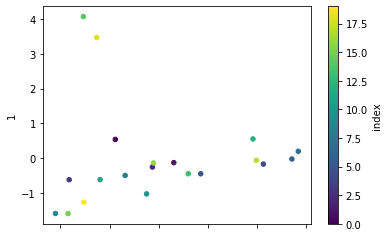

In [152]:
pca_result.plot.scatter(x=0, y=1,
                      c='index',
                      colormap='viridis')